All necesarry pacakeges to install
--

In [84]:
# !pip install stop-words

# Data visualiazation pre-processing and trained Baseline Model: Random Forest, Decision trees, XGB.

All the packeges
--

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import re
import string
from collections import Counter
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


# Download required NLTK resources

In [22]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Step 1: Load and explore the dataset
# Load the training and test datasets

In [29]:
# Load your training dataset
train_df = pd.read_csv('/kaggle/input/sm-technology-dataset/train.csv')

# Split train into train and validation sets (80% train, 20% validation)
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

print(f"Original training data shape: {train_df.shape}")
print(f"New training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Original training data shape: (12120, 6)
New training data shape: (9696, 6)
Validation data shape: (2424, 6)


# Display the first few rows of the training data

In [30]:
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


# Check data information

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


# Summary statistics

In [32]:
train_df.describe()

,label
count,12120.000000
mean,0.990759
std,0.824523
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


# Check for missing values

In [73]:
# Check for missing values
print("Missing values in each column:")
print(train_df.isnull().sum())

# Calculate percentage of missing values
print("\nPercentage of missing values:")
print((train_df.isnull().sum() / len(train_df) * 100).round(2))

Missing values in each column:
id                       0
premise                  0
hypothesis               0
lang_abv                 0
language                 0
label                    0
label_name               0
premise_length           0
hypothesis_length        0
length_diff              0
premise_word_count       0
hypothesis_word_count    0
word_count_diff          0
dtype: int64

Percentage of missing values:
id                       0.0
premise                  0.0
hypothesis               0.0
lang_abv                 0.0
language                 0.0
label                    0.0
label_name               0.0
premise_length           0.0
hypothesis_length        0.0
length_diff              0.0
premise_word_count       0.0
hypothesis_word_count    0.0
word_count_diff          0.0
dtype: float64


# Check class distribution

In [34]:
print("\n--- Class Distribution ---")
class_counts = train_df['label'].value_counts()
print(class_counts)


--- Class Distribution ---
label
0    4176
2    4064
1    3880
Name: count, dtype: int64


# Visualize class distribution

Text(0, 0.5, 'Count')

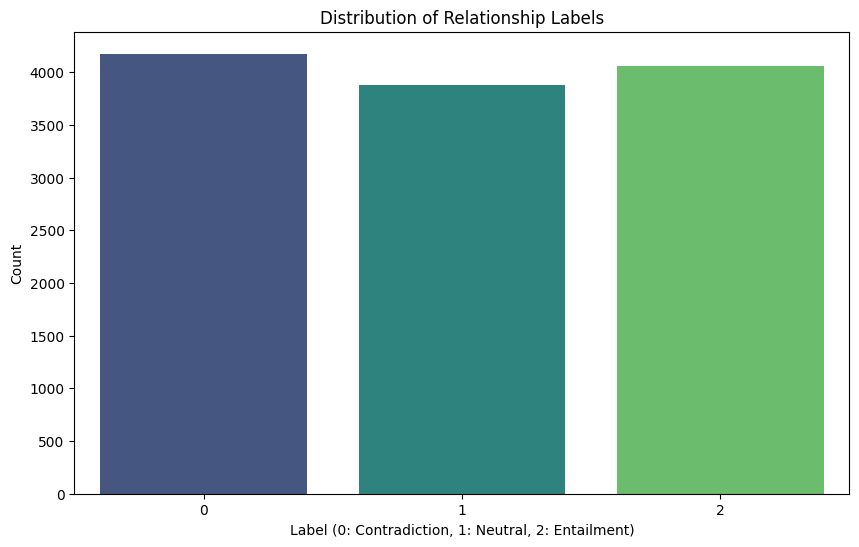

In [48]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=train_df, palette='viridis')
plt.title('Distribution of Relationship Labels')
plt.xlabel('Label (0: Contradiction, 1: Neutral, 2: Entailment)')
plt.ylabel('Count')

# Add count labels on top of bars

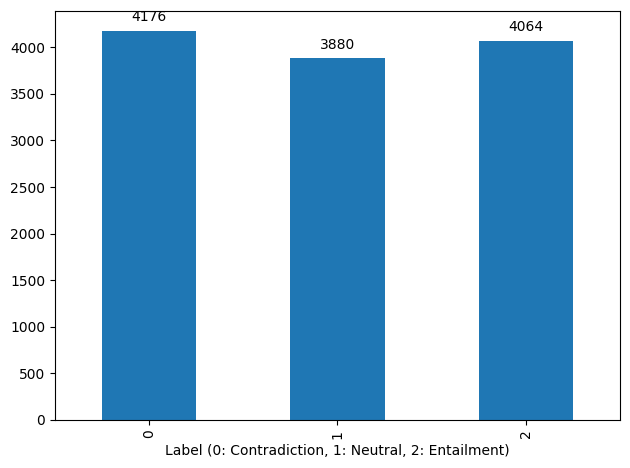

In [56]:
# Create the bar chart
ax = train_df['label'].value_counts().sort_index().plot(kind='bar')

# Add the x-axis labels if needed
plt.xlabel('Label (0: Contradiction, 1: Neutral, 2: Entailment)')

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# Text length analysis

In [54]:
train_df.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label',
       'label_name', 'premise_length', 'hypothesis_length', 'length_diff',
       'premise_word_count', 'hypothesis_word_count', 'word_count_diff'],
      dtype='object')

In [58]:
train_df['premise_length'] = train_df['premise'].apply(len)
train_df['hypothesis_length'] = train_df['hypothesis'].apply(len)
train_df['premise_word_count'] = train_df['premise'].apply(lambda x: len(str(x).split()))
train_df['hypothesis_word_count'] = train_df['hypothesis'].apply(lambda x: len(str(x).split()))

In [59]:
# Summary statistics of text length
print("\nText Length Statistics:")
length_stats = train_df[['premise_length', 'hypothesis_length', 
                         'premise_word_count', 'hypothesis_word_count']].describe()
print(length_stats)



Text Length Statistics:
       premise_length  hypothesis_length  premise_word_count  \
count    12120.000000       12120.000000        12120.000000   
mean       107.373185          53.892327           17.990182   
std         71.089954          25.302358           12.898411   
min          4.000000           4.000000            1.000000   
25%         55.000000          36.000000            9.000000   
50%         96.000000          51.000000           16.000000   
75%        146.000000          67.000000           25.000000   
max        967.000000         276.000000          196.000000   

       hypothesis_word_count  
count           12120.000000  
mean                9.195297  
std                 4.650281  
min                 1.000000  
25%                 6.000000  
50%                 9.000000  
75%                12.000000  
max                46.000000  


# Text length distribution by class

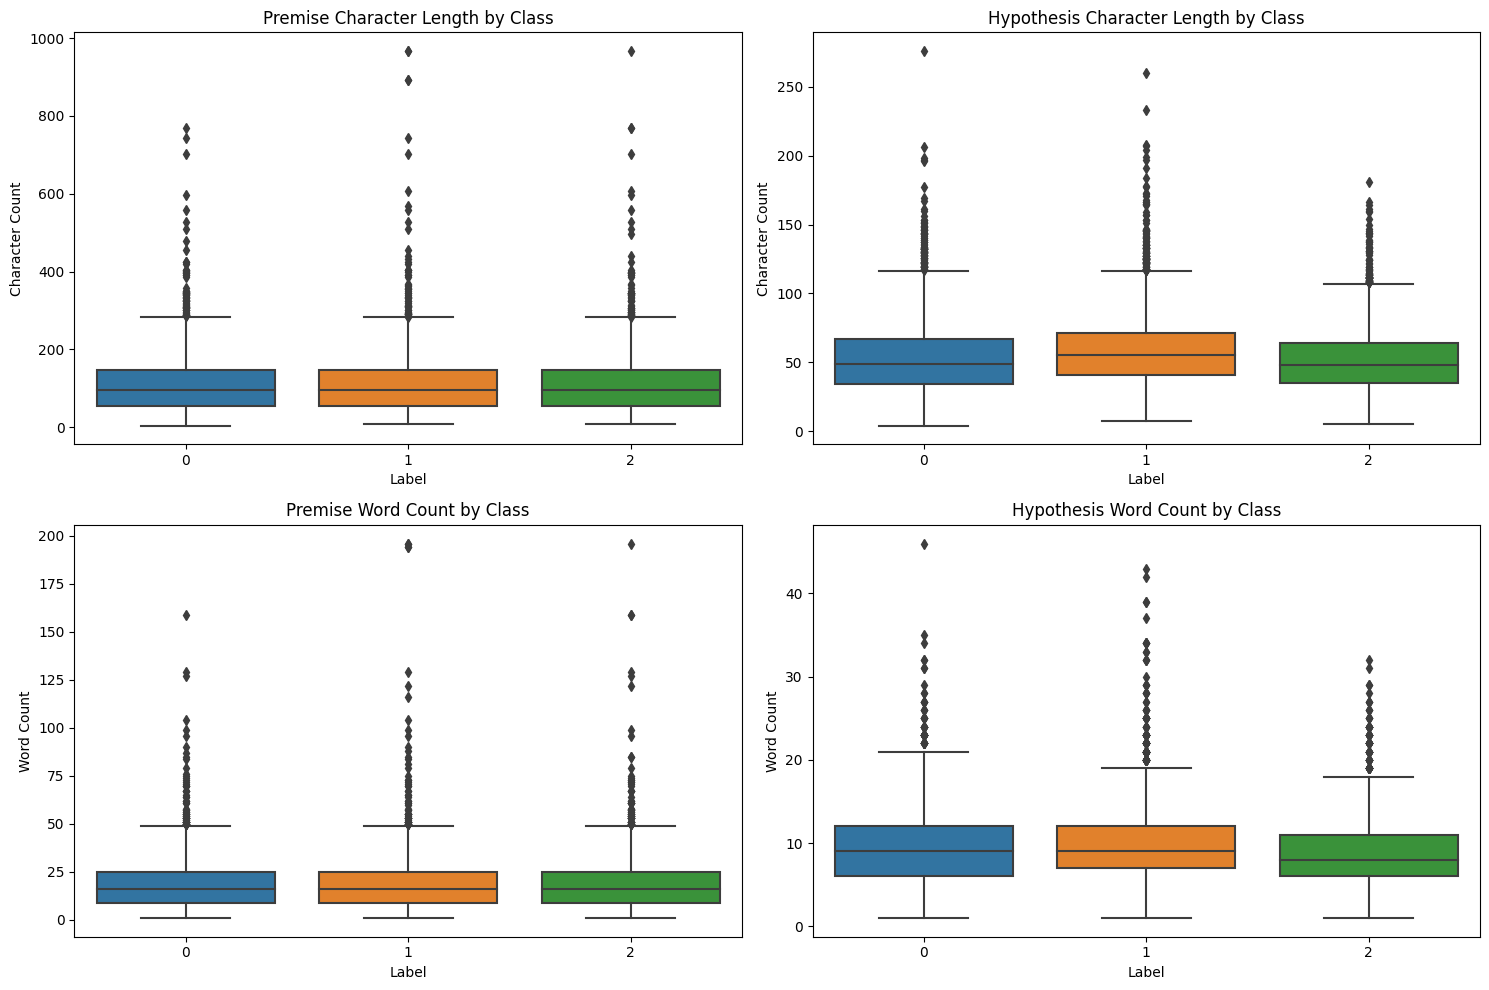

In [62]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='label', y='premise_length', data=train_df)
plt.title('Premise Character Length by Class')
plt.xlabel('Label')
plt.ylabel('Character Count')

plt.subplot(2, 2, 2)
sns.boxplot(x='label', y='hypothesis_length', data=train_df)
plt.title('Hypothesis Character Length by Class')
plt.xlabel('Label')
plt.ylabel('Character Count')

plt.subplot(2, 2, 3)
sns.boxplot(x='label', y='premise_word_count', data=train_df)
plt.title('Premise Word Count by Class')
plt.xlabel('Label')
plt.ylabel('Word Count')

plt.subplot(2, 2, 4)
sns.boxplot(x='label', y='hypothesis_word_count', data=train_df)
plt.title('Hypothesis Word Count by Class')
plt.xlabel('Label')
plt.ylabel('Word Count')

plt.tight_layout()
plt.savefig('text_length_by_class.png')
plt.show()

# Word frequency analysis

In [70]:
def get_top_words(text_data, top_n=20):
    """
    Extract the top N most common words from text data.
    
    Parameters:
    text_data: Either pd.Series or list containing text data
    top_n (int): Number of top words to return
    
    Returns:
    list: List of tuples (word, count) sorted by count in descending order
    """
    from collections import Counter
    import re
    import pandas as pd
    
    # Convert to pandas Series if it's a list
    if isinstance(text_data, list):
        text_series = pd.Series(text_data)
    else:
        text_series = text_data
    
    # Combine all text, convert to lowercase, and split into words
    all_words = ' '.join(text_series.fillna('').astype(str)).lower()
    # Remove punctuation and split
    words = re.findall(r'\b\w+\b', all_words)
    
    # Count words and get top N
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

In [71]:
print("\nTop words analysis:")
for label_value, label_name in [(0, 'Contradiction'), (1, 'Neutral'), (2, 'Entailment')]:
    class_df = train_df[train_df['label'] == label_value]
    premise_top_words = get_top_words(class_df['premise'])
    hypothesis_top_words = get_top_words(class_df['hypothesis'])
    
    print(f"\nTop 20 words in {label_name} premises:")
    for word, count in premise_top_words:
        print(f"{word}: {count}")
    
    print(f"\nTop 20 words in {label_name} hypotheses:")
    for word, count in hypothesis_top_words:
        print(f"{word}: {count}")


Top words analysis:

Top 20 words in Contradiction premises:
the: 2846
and: 1439
of: 1413
to: 1208
a: 1111
in: 850
i: 702
that: 683
it: 638
s: 596
you: 519
क: 448
is: 429
for: 407
de: 344
was: 316
with: 295
on: 290
they: 281
as: 278

Top 20 words in Contradiction hypotheses:
the: 1576
to: 699
a: 636
of: 560
is: 465
in: 396
and: 388
it: 327
that: 322
i: 312
was: 305
are: 241
क: 238
for: 224
s: 212
be: 192
you: 186
there: 164
have: 157
not: 154

Top 20 words in Neutral premises:
the: 2536
and: 1307
of: 1292
to: 1061
a: 1011
in: 745
i: 691
that: 627
it: 607
s: 543
you: 451
क: 425
for: 415
is: 394
de: 329
they: 270
on: 257
with: 250
was: 246
as: 245

Top 20 words in Neutral hypotheses:
the: 1576
to: 736
of: 516
a: 515
in: 403
is: 375
was: 342
and: 326
i: 300
it: 295
क: 250
for: 245
are: 243
that: 229
be: 191
they: 181
s: 173
he: 160
have: 150
de: 148

Top 20 words in Entailment premises:
the: 2665
and: 1337
of: 1320
to: 1130
a: 1079
in: 788
i: 721
that: 654
it: 630
s: 559
क: 536
you: 504


# Visualize top words overall

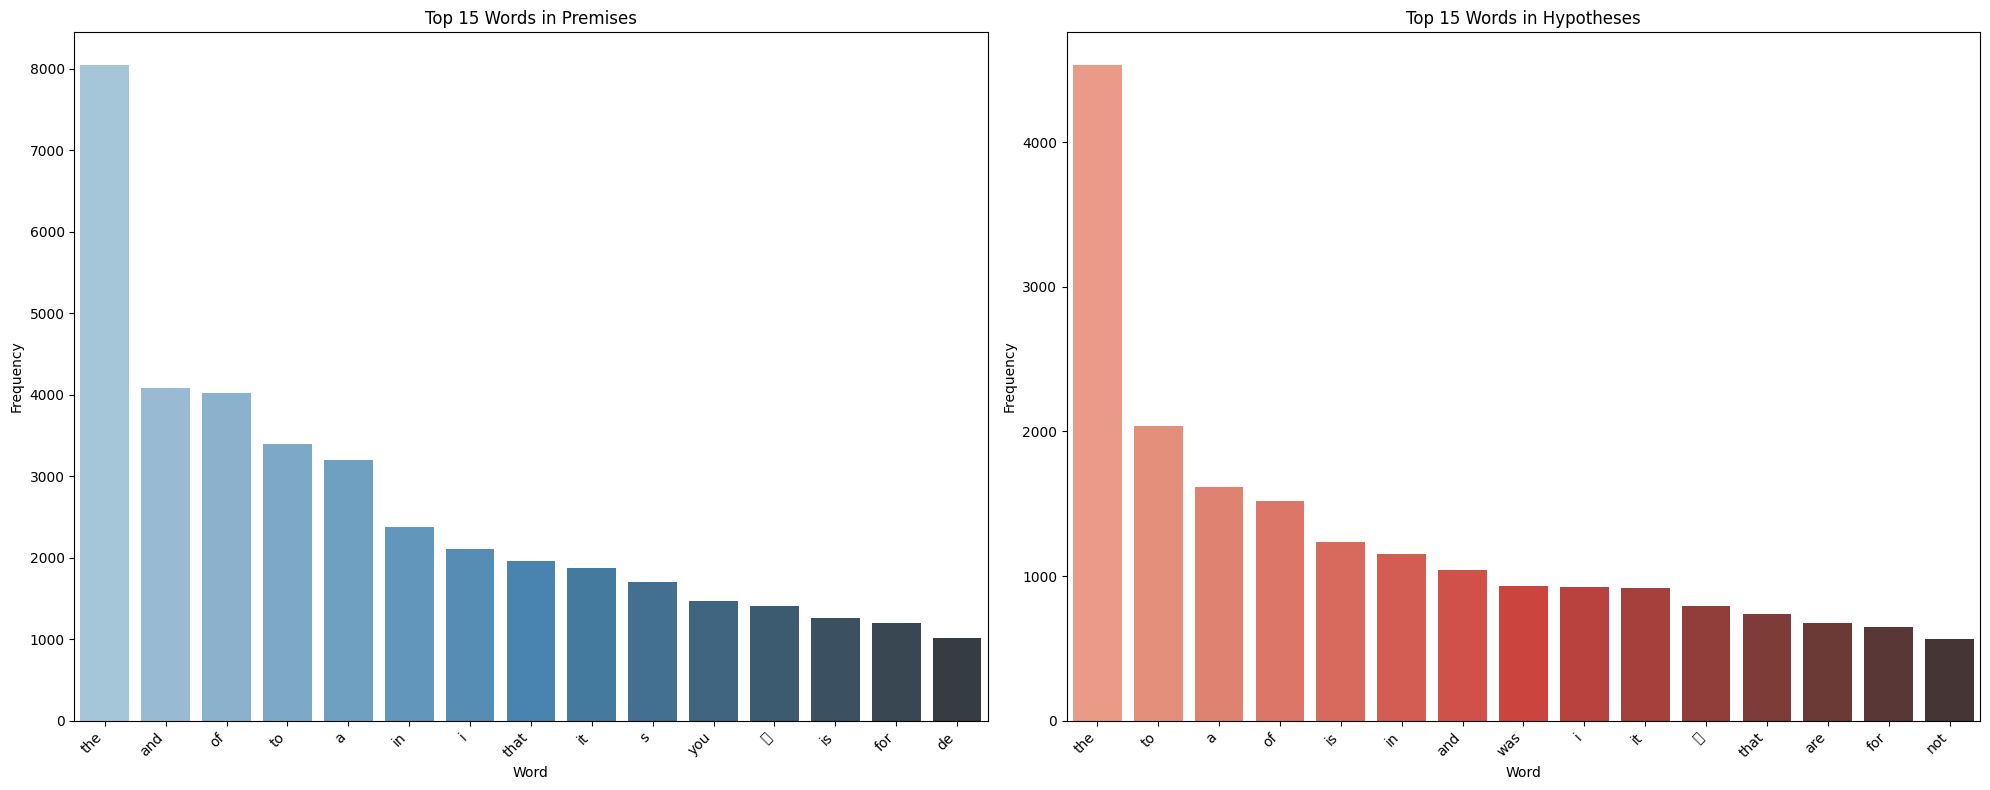

In [72]:
# Visualize top words overall
all_premises = train_df['premise'].tolist()
all_hypotheses = train_df['hypothesis'].tolist()

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
premise_words = get_top_words(all_premises, top_n=15)
sns.barplot(x=[word for word, count in premise_words], 
            y=[count for word, count in premise_words], 
            palette='Blues_d')
plt.title('Top 15 Words in Premises')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
hypothesis_words = get_top_words(all_hypotheses, top_n=15)
sns.barplot(x=[word for word, count in hypothesis_words], 
            y=[count for word, count in hypothesis_words], 
            palette='Reds_d')
plt.title('Top 15 Words in Hypotheses')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('top_words.png')
plt.show()


# Check for outliers.

In [78]:
# Check for outliers in numeric columns
numeric_cols = ['premise_length', 'hypothesis_length', 'premise_word_count', 'hypothesis_word_count']

# Statistical summary to get an overview
print("Statistical summary:")
print(train_df[numeric_cols].describe())

# Calculate outliers using IQR method
print("\nOutlier analysis using IQR method:")
for col in numeric_cols:
    q1 = train_df[col].quantile(0.25)
    q3 = train_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    print(f"\nOutliers in {col}:")
    print(f"  Count: {len(outliers)} ({len(outliers)/len(train_df)*100:.2f}%)")
    print(f"  Range: {outliers[col].min()} to {outliers[col].max()}")
    print(f"  Acceptable range: {lower_bound:.2f} to {upper_bound:.2f}")

Statistical summary:
       premise_length  hypothesis_length  premise_word_count  \
count    12120.000000       12120.000000        12120.000000   
mean       107.373185          53.892327           17.990182   
std         71.089954          25.302358           12.898411   
min          4.000000           4.000000            1.000000   
25%         55.000000          36.000000            9.000000   
50%         96.000000          51.000000           16.000000   
75%        146.000000          67.000000           25.000000   
max        967.000000         276.000000          196.000000   

       hypothesis_word_count  
count           12120.000000  
mean                9.195297  
std                 4.650281  
min                 1.000000  
25%                 6.000000  
50%                 9.000000  
75%                12.000000  
max                46.000000  

Outlier analysis using IQR method:

Outliers in premise_length:
  Count: 184 (1.52%)
  Range: 283 to 967
  Acceptable rang

# Detect language for a sample of text

In [85]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import langid
from stop_words import get_stop_words
import spacy
import os


In [89]:
def detect_language(text):
    """
    Detect the language of a text using langid
    
    Args:
        text (str): Input text
    
    Returns:
        str: Detected language code
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 'en'  # Default to English for empty strings
    
    try:
        lang, _ = langid.classify(text)
        return lang
    except:
        return 'en'  # Default to English if detection fails

# Analyze language distribution in the dataset

In [90]:
def analyze_language_distribution(df):
    """
    Analyze the language distribution in the dataset
    
    Args:
        df (DataFrame): Input dataframe with premise and hypothesis
    
    Returns:
        dict: Language distribution
    """
    print("Detecting languages in the dataset (sampling 1000 examples)...")
    # Sample to speed up analysis
    sample_size = min(1000, len(df))
    sample_df = df.sample(sample_size, random_state=42)
    
    premise_langs = [detect_language(text) for text in tqdm(sample_df['premise'])]
    hypothesis_langs = [detect_language(text) for text in tqdm(sample_df['hypothesis'])]
    
    all_langs = premise_langs + hypothesis_langs
    lang_distribution = pd.Series(all_langs).value_counts()
    
    return lang_distribution

In [91]:
# Analyze language distribution
language_distribution = analyze_language_distribution(train_df)
print("\nLanguage distribution in the dataset:")
print(language_distribution)

Detecting languages in the dataset (sampling 1000 examples)...


100%|██████████| 1000/1000 [00:00<00:00, 1123.47it/s]


Language distribution in the dataset:
en    1165
fr      74
ru      72
ur      69
vi      66
zh      64
sw      59
th      58
bg      57
el      56
de      52
es      51
hi      50
ar      41
tr      37
fa       4
tl       3
ca       3
id       2
it       2
hr       2
af       1
et       1
lt       1
lv       1
sl       1
mr       1
ro       1
mk       1
pl       1
az       1
fi       1
ne       1
nl       1
Name: count, dtype: int64


# Load spaCy models for major languages detected

In [92]:

def load_spacy_models(language_distribution):
    """
    Load spaCy models for the most common languages in the dataset
    
    Args:
        language_distribution (Series): Language distribution
    
    Returns:
        dict: Dictionary of spaCy models
    """
    models = {}
    
    # Define language model mapping
    lang_model_map = {
        'en': 'en_core_web_sm',
        'es': 'es_core_news_sm',
        'fr': 'fr_core_news_sm',
        'de': 'de_core_news_sm',
        'it': 'it_core_news_sm',
        'pt': 'pt_core_news_sm',
        'nl': 'nl_core_news_sm',
        'xx': 'xx_ent_wiki_sm'  # For languages without specific models
    }
    
    print("\nLoading spaCy models for major languages...")
    
    # Get the top 5 most common languages
    top_langs = language_distribution.index[:5].tolist()
    
    # Always include English
    if 'en' not in top_langs:
        top_langs.append('en')
    
    # Load models for top languages
    for lang in top_langs:
        model_name = lang_model_map.get(lang)
        
        if model_name:
            try:
                # Check if model is installed
                if not spacy.util.is_package(model_name):
                    print(f"spaCy model {model_name} not found. Installing...")
                    os.system(f"python -m spacy download {model_name}")
                
                models[lang] = spacy.load(model_name)
                print(f"Loaded spaCy model for {lang}")
            except:
                print(f"Failed to load model for {lang}, will use alternative processing")
    
    # Add multilingual model for other languages
    try:
        model_name = lang_model_map['xx']
        if not spacy.util.is_package(model_name):
            print(f"spaCy model {model_name} not found. Installing...")
            os.system(f"python -m spacy download {model_name}")
        
        models['xx'] = spacy.load(model_name)
        print("Loaded multilingual spaCy model")
    except:
        print("Failed to load multilingual model")
    
    return models

In [93]:
# Load spaCy models
spacy_models = load_spacy_models(language_distribution)


Loading spaCy models for major languages...
Loaded spaCy model for en
spaCy model fr_core_news_sm not found. Installing...
Loaded spaCy model for fr
spaCy model xx_ent_wiki_sm not found. Installing...
Loaded multilingual spaCy model


# Get stopwords for multiple languages

In [94]:
def get_multilingual_stopwords():
    """
    Get stopwords for multiple languages
    
    Returns:
        dict: Dictionary of stopwords by language
    """
    stopwords_dict = {}
    
    # Languages supported by stop-words package
    languages = ['en', 'es', 'fr', 'de', 'it', 'pt', 'ru', 'nl', 'fi', 'sv', 'da', 'pl', 'hu', 'ro', 'cs']
    
    for lang in languages:
        try:
            stopwords_dict[lang] = get_stop_words(lang)
            print(f"Loaded stopwords for {lang}")
        except:
            print(f"Could not load stopwords for {lang}")
    
    return stopwords_dict

# Get stopwords for multiple languages
multilingual_stopwords = get_multilingual_stopwords()

Loaded stopwords for en
Loaded stopwords for es
Loaded stopwords for fr
Loaded stopwords for de
Loaded stopwords for it
Loaded stopwords for pt
Loaded stopwords for ru
Loaded stopwords for nl
Loaded stopwords for fi
Loaded stopwords for sv
Loaded stopwords for da
Loaded stopwords for pl
Loaded stopwords for hu
Loaded stopwords for ro
Could not load stopwords for cs


Cleaning the text dataset
--

In [95]:
def clean_text(text, lang=None, remove_stopwords=True, lemmatize=True):
    """
    Function to clean and preprocess text in multiple languages
    
    Args:
        text (str): Input text
        lang (str): Language code
        remove_stopwords (bool): Whether to remove stopwords
        lemmatize (bool): Whether to apply lemmatization
    
    Returns:
        list: List of processed tokens
        str: Processed text string
    """
    if not isinstance(text, str):
        text = str(text)
    
    # Detect language if not provided
    if lang is None:
        lang = detect_language(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special characters and punctuation
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Use spaCy for tokenization and lemmatization if available for the language
    if lang in spacy_models:
        doc = spacy_models[lang](text)
        
        # Get tokens and lemmas
        if lemmatize:
            tokens = [token.lemma_ for token in doc]
        else:
            tokens = [token.text for token in doc]
        
        # Remove stopwords if requested
        if remove_stopwords:
            if lang in multilingual_stopwords:
                stop_words = set(multilingual_stopwords[lang])
                tokens = [token for token in tokens if token not in stop_words]
    
    # Fallback to basic tokenization for languages without spaCy models
    else:
        # Use NLTK for tokenization
        tokens = word_tokenize(text)
        
        # Remove stopwords if requested
        if remove_stopwords and lang in multilingual_stopwords:
            stop_words = set(multilingual_stopwords[lang])
            tokens = [token for token in tokens if token not in stop_words]
    
    # Join tokens back into a string
    processed_text = ' '.join(tokens)
    
    return tokens, processed_text

# Function to process all sentences in the dataset

In [96]:
def process_dataset(df):
    """
    Process both sentences in the dataset with language detection
    
    Args:
        df (DataFrame): Input dataframe with premise and hypothesis
        
    Returns:
        DataFrame: Processed dataframe with additional columns
    """
    processed_df = df.copy()
    
    # Detect language for all sentences
    print("Detecting language for all sentences...")
    premise_langs = [detect_language(text) for text in tqdm(df['premise'])]
    hypothesis_langs = [detect_language(text) for text in tqdm(df['hypothesis'])]
    processed_df['premise_lang'] = premise_langs
    processed_df['hypothesis_lang'] = hypothesis_langs
    
    # Process premise
    premise_tokens = []
    processed_premises = []
    print("Processing premises...")
    for text, lang in tqdm(zip(df['premise'], premise_langs), total=len(df)):
        tokens, processed_text = clean_text(text, lang=lang)
        premise_tokens.append(tokens)
        processed_premises.append(processed_text)
    
    # Process hypothesis
    hypothesis_tokens = []
    processed_hypotheses = []
    print("Processing hypotheses...")
    for text, lang in tqdm(zip(df['hypothesis'], hypothesis_langs), total=len(df)):
        tokens, processed_text = clean_text(text, lang=lang)
        hypothesis_tokens.append(tokens)
        processed_hypotheses.append(processed_text)
    
    # Add processed data to dataframe
    processed_df['premise_tokens'] = premise_tokens
    processed_df['processed_premise'] = processed_premises
    processed_df['hypothesis_tokens'] = hypothesis_tokens
    processed_df['processed_hypothesis'] = processed_hypotheses
    
    return processed_df

# Apply preprocessing to both datasets

In [97]:
print("Preprocessing training data...")
processed_train = process_dataset(train_data)
print("Preprocessing validation data...")
processed_val = process_dataset(val_data)

Preprocessing training data...
Detecting language for all sentences...


100%|██████████| 9696/9696 [00:08<00:00, 1118.77it/s]


Processing premises...


100%|██████████| 9696/9696 [00:48<00:00, 201.62it/s]


Processing hypotheses...


100%|██████████| 9696/9696 [00:37<00:00, 255.34it/s]


Preprocessing validation data...
Detecting language for all sentences...


100%|██████████| 2424/2424 [00:02<00:00, 1080.23it/s]


Processing premises...


100%|██████████| 2424/2424 [00:11<00:00, 205.61it/s]


Processing hypotheses...


100%|██████████| 2424/2424 [00:09<00:00, 261.67it/s]


# Display a few examples of processed text

In [101]:
print(f"Total rows in processed_train: {len(processed_train)}")

# Print the actual indices of the DataFrame
print("Available indices:")
print(processed_train.index.tolist()[:10])  # Show first 10 indices

# Use this safer approach to print examples:
print("\nExample of processed text:")
for i, (idx, row) in enumerate(processed_train.iterrows()):
    if i >= 3:  # Only show first 3 examples
        break
    print(f"\nOriginal premise: {row['premise']}")
    print(f"Language: {row['premise_lang']}")
    print(f"Processed premise: {row['processed_premise']}")
    print(f"Original hypothesis: {row['hypothesis']}")
    print(f"Language: {row['hypothesis_lang']}")
    print(f"Processed hypothesis: {row['processed_hypothesis']}")

Total rows in processed_train: 9696
Available indices:
[10734, 11976, 3294, 10870, 7100, 5752, 7715, 7936, 9595, 5030]

Example of processed text:

Original premise:  8th circa b.c.Greeks colonize Sicily and other southern regions
Language: en
Processed premise: 8th circa b c greek colonize sicily southern region
Original hypothesis: Sicily and other southern regions were colonized in the 8th century b.c.
Language: en
Processed hypothesis: sicily southern region colonize 8th century b c

Original premise: لدي شيء لأريك إياه، متسائلاً، ركب اللورد جوليان المرافق، كما قيل له.
Language: ar
Processed premise: لدي شيء لأريك إياه، متسائلاً، ركب اللورد جوليان المرافق، كما قيل له
Original hypothesis: نزل جوليان من جبله لأنه أخبره أنه ليس لديه ما يظهره.
Language: ar
Processed hypothesis: نزل جوليان من جبله لأنه أخبره أنه ليس لديه ما يظهره

Original premise: Porches and stoops, those symbols of a vibrant social life, stopped being used as gathering places for a rather practical reason--air condit

# Feature Extraction - TF-IDF (language-agnostic)

In [102]:

print("\nExtracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Fit on train data (combining premise and hypothesis)
combined_train_text = processed_train['processed_premise'] + ' ' + processed_train['processed_hypothesis']
tfidf_features_train = tfidf_vectorizer.fit_transform(combined_train_text)

# Transform validation data
combined_val_text = processed_val['processed_premise'] + ' ' + processed_val['processed_hypothesis']
tfidf_features_val = tfidf_vectorizer.transform(combined_val_text)

print(f"TF-IDF features shape (train): {tfidf_features_train.shape}")
print(f"TF-IDF features shape (val): {tfidf_features_val.shape}")



Extracting TF-IDF features...
TF-IDF features shape (train): (9696, 10000)
TF-IDF features shape (val): (2424, 10000)


# Feature Extraction - Word2Vec (multilingual)

In [103]:
print("\nTraining Word2Vec model...")
# Combine all tokenized sentences for training Word2Vec
all_sentences = (processed_train['premise_tokens'].tolist() + 
                processed_train['hypothesis_tokens'].tolist() +
                processed_val['premise_tokens'].tolist() + 
                processed_val['hypothesis_tokens'].tolist())

# Train Word2Vec model
w2v_model = Word2Vec(sentences=all_sentences, 
                    vector_size=300,  # Increased dimension for multilingual data
                    window=5,         # Context window size
                    min_count=2,      # Minimum word frequency
                    workers=4,        # Number of parallel workers
                    sg=1)             # Use skip-gram model



Training Word2Vec model...


In [105]:
# Function to create sentence embedding from Word2Vec
def get_w2v_embedding(tokens, model, embedding_size=300):
    embedding = np.zeros(embedding_size)
    valid_tokens = 0
    
    for token in tokens:
        if token in model.wv:
            embedding += model.wv[token]
            valid_tokens += 1
    
    if valid_tokens > 0:
        embedding /= valid_tokens
    
    return embedding

# Extract Word2Vec features

In [106]:

print("\nExtracting Word2Vec features...")
# For training data
train_premise_w2v = np.array([get_w2v_embedding(tokens, w2v_model) 
                             for tokens in tqdm(processed_train['premise_tokens'])])
train_hypothesis_w2v = np.array([get_w2v_embedding(tokens, w2v_model) 
                                for tokens in tqdm(processed_train['hypothesis_tokens'])])

# For validation data
val_premise_w2v = np.array([get_w2v_embedding(tokens, w2v_model) 
                           for tokens in tqdm(processed_val['premise_tokens'])])
val_hypothesis_w2v = np.array([get_w2v_embedding(tokens, w2v_model) 
                              for tokens in tqdm(processed_val['hypothesis_tokens'])])


Extracting Word2Vec features...


100%|██████████| 2424/2424 [00:00<00:00, 41339.32it/s]


In [107]:
print(f"Word2Vec embedding shape for premise (train): {train_premise_w2v.shape}")
print(f"Word2Vec embedding shape for hypothesis (train): {train_hypothesis_w2v.shape}")

Word2Vec embedding shape for premise (train): (9696, 300)
Word2Vec embedding shape for hypothesis (train): (9696, 300)


# Feature Extraction - Multilingual Transformer (XLM-RoBERTa)

In [108]:
print("\nExtracting XLM-RoBERTa embeddings...")
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load XLM-RoBERTa model and tokenizer (multilingual model)
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base").to(device)



Extracting XLM-RoBERTa embeddings...
Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

# Function to get transformer embeddings

In [109]:
def get_transformer_embedding(text, tokenizer, model, device, max_length=128):
    # Tokenize and prepare input
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", 
                      truncation=True, max_length=max_length)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use the last hidden state of the [CLS] token as sentence representation
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embeddings[0]  # Return as 1D array


# Extract XLM-RoBERTa embeddings for a sample of examples

In [111]:
sample_size = min(100, len(processed_train))
print(f"Extracting XLM-RoBERTa embeddings for a sample of {sample_size} examples...")
train_premise_xlm = np.array([get_transformer_embedding(text, tokenizer, model, device) 
                              for text in tqdm(processed_train['premise'][:sample_size])])
train_hypothesis_xlm = np.array([get_transformer_embedding(text, tokenizer, model, device) 
                                 for text in tqdm(processed_train['hypothesis'][:sample_size])])
print(f"XLM-RoBERTa embedding shape for premise (sample): {train_premise_xlm.shape}")
print(f"XLM-RoBERTa embedding shape for hypothesis (sample): {train_hypothesis_xlm.shape}")

Extracting XLM-RoBERTa embeddings for a sample of 100 examples...


100%|██████████| 100/100 [00:00<00:00, 109.37it/s]

XLM-RoBERTa embedding shape for premise (sample): (100, 768)
XLM-RoBERTa embedding shape for hypothesis (sample): (100, 768)


# Save processed data and features

In [207]:
print("\nSaving processed data and features...")
# Save processed text data
processed_train.to_csv('multilingual_processed_train_text.csv', index=False)
processed_val.to_csv('multilingual_processed_val_text.csv', index=False)



Saving processed data and features...


# Save TF-IDF features

In [195]:
np.save('multilingual_train_tfidf_features.npy', tfidf_features_train.toarray())
np.save('multilingual_val_tfidf_features.npy', tfidf_features_val.toarray())

# Save Word2Vec features

In [208]:
np.save('multilingual_train_premise_w2v.npy', train_premise_w2v)
np.save('multilingual_train_hypothesis_w2v.npy', train_hypothesis_w2v)
np.save('multilingual_val_premise_w2v.npy', val_premise_w2v)
np.save('multilingual_val_hypothesis_w2v.npy', val_hypothesis_w2v)

# Save sample XLM-RoBERTa features

In [210]:
np.save('multilingual_train_premise_xlm_sample.npy', train_premise_xlm)
np.save('multilingual_train_hypothesis_xlm_sample.npy', train_hypothesis_xlm)

Model Trainning part started
--

In [227]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, AdamW, get_linear_schedule_with_warmup
from transformers import XLMRobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset as HFDataset
import optuna
from tqdm import tqdm
import os
import json
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility

In [228]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Load data

In [230]:
def load_data():
    """Load and prepare all data."""
    logger.info("Loading preprocessed data...")
    processed_train = pd.read_csv('multilingual_processed_train_text.csv')
    processed_val = pd.read_csv('multilingual_processed_val_text.csv')

    logger.info("Loading TF-IDF features...")
    train_tfidf = np.load('multilingual_train_tfidf_features.npy')
    val_tfidf = np.load('multilingual_val_tfidf_features.npy')

    logger.info("Loading Word2Vec features...")
    train_premise_w2v = np.load('multilingual_train_premise_w2v.npy')
    train_hypothesis_w2v = np.load('multilingual_train_hypothesis_w2v.npy')
    val_premise_w2v = np.load('multilingual_val_premise_w2v.npy')
    val_hypothesis_w2v = np.load('multilingual_val_hypothesis_w2v.npy')

    # Combine Word2Vec features
    train_w2v_combined = np.concatenate([train_premise_w2v, train_hypothesis_w2v, 
                                       train_premise_w2v - train_hypothesis_w2v,
                                       np.multiply(train_premise_w2v, train_hypothesis_w2v)], axis=1)
    val_w2v_combined = np.concatenate([val_premise_w2v, val_hypothesis_w2v, 
                                     val_premise_w2v - val_hypothesis_w2v,
                                     np.multiply(val_premise_w2v, val_hypothesis_w2v)], axis=1)

    # Print shapes to debug
    print(f"Original data shapes:")
    print(f"processed_train: {processed_train.shape}")
    print(f"processed_val: {processed_val.shape}")
    print(f"train_tfidf: {train_tfidf.shape}")
    print(f"val_tfidf: {val_tfidf.shape}")
    print(f"train_w2v_combined: {train_w2v_combined.shape}")
    print(f"val_w2v_combined: {val_w2v_combined.shape}")

    # Check label distribution
    print("\nLabel distribution in training data:")
    print(processed_train['label'].value_counts(dropna=False))
    print("\nLabel distribution in validation data:")
    print(processed_val['label'].value_counts(dropna=False))

    # Prepare labels (using integers directly)
    y_train = processed_train['label'].values
    y_val = processed_val['label'].values

    # Check for NaN values
    if np.isnan(y_train).any():
        print(f"Found {np.isnan(y_train).sum()} NaN values in y_train. Filling with 1...")
        y_train = np.nan_to_num(y_train, nan=1)
    if np.isnan(y_val).any():
        print(f"Found {np.isnan(y_val).sum()} NaN values in y_val. Filling with 1...")
        y_val = np.nan_to_num(y_val, nan=1)

    # Create texts for transformer models
    train_texts = [{'premise': str(row['premise']), 'hypothesis': str(row['hypothesis'])} 
                   for _, row in processed_train.iterrows()]
    val_texts = [{'premise': str(row['premise']), 'hypothesis': str(row['hypothesis'])} 
                 for _, row in processed_val.iterrows()]

    # Define label map for interpretation
    label_map = {0: "entailment", 1: "neutral", 2: "contradiction"}
    
    return {
        'processed_train': processed_train,
        'processed_val': processed_val,
        'train_tfidf': train_tfidf,
        'val_tfidf': val_tfidf, 
        'train_w2v_combined': train_w2v_combined,
        'val_w2v_combined': val_w2v_combined,
        'y_train': y_train,
        'y_val': y_val,
        'train_texts': train_texts,
        'val_texts': val_texts,
        'label_map': label_map
    }

# Execute the function
data = load_data()

Original data shapes:
processed_train: (9696, 19)
processed_val: (2424, 19)
train_tfidf: (9696, 10000)
val_tfidf: (2424, 10000)
train_w2v_combined: (9696, 1200)
val_w2v_combined: (2424, 1200)

Label distribution in training data:
label
0    3341
2    3251
1    3104
Name: count, dtype: int64

Label distribution in validation data:
label
0    835
2    813
1    776
Name: count, dtype: int64


# Define Random Forest Tuning

In [235]:
# Cell 4: Define Random Forest Tuning
def tune_random_forest(data):
    """Tune Random Forest model with TF-IDF features using RandomizedSearchCV."""
    logger.info("\n======== TUNING RANDOM FOREST WITH TF-IDF ========")
    
    # Define parameter grid
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False],
        'class_weight': [None, 'balanced']
    }
    
    rf_clf = RandomForestClassifier(random_state=SEED)
    rf_search = RandomizedSearchCV(
        rf_clf, 
        rf_param_grid, 
        n_iter=10,  # Reduced for faster execution in notebook
        cv=3, 
        scoring='accuracy',
        random_state=SEED,
        n_jobs=-1,
        verbose=1
    )
    
    logger.info("Tuning Random Forest with TF-IDF features...")
    rf_search.fit(data['train_tfidf'], data['y_train'])
    
    logger.info(f"Best parameters for RF TF-IDF: {rf_search.best_params_}")
    logger.info(f"Best CV accuracy: {rf_search.best_score_:.4f}")
    
    best_rf_tfidf = rf_search.best_estimator_
    val_preds = best_rf_tfidf.predict(data['val_tfidf'])
    val_acc = accuracy_score(data['y_val'], val_preds)
    logger.info(f"Validation accuracy: {val_acc:.4f}")
    logger.info(f"Classification Report:\n{classification_report(data['y_val'], val_preds, target_names=data['label_map'].values())}")
    
    return best_rf_tfidf, val_acc, rf_search.best_params_

# Cell 5: Execute Random Forest Tuning

In [236]:
best_rf, rf_acc, rf_params = tune_random_forest(data)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


# Print the metrics Random Forest

In [237]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# After you've trained your model and obtained the best estimator
best_rf, val_acc, rf_params = tune_random_forest(data)

# Get predictions on validation set
val_predictions = best_rf.predict(data['val_tfidf'])

# Calculate individual metrics
accuracy = accuracy_score(data['y_val'], val_predictions)
precision = precision_score(data['y_val'], val_predictions, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(data['y_val'], val_predictions, average='weighted')
f1 = f1_score(data['y_val'], val_predictions, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# For a detailed report per class
print("\nDetailed Classification Report:")
print(classification_report(data['y_val'], val_predictions, target_names=data['label_map'].values()))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Accuracy: 0.3787
Precision: 0.3907
Recall: 0.3787
F1 Score: 0.3524

Detailed Classification Report:
               precision    recall  f1-score   support

   entailment       0.37      0.67      0.47       835
      neutral       0.34      0.20      0.25       776
contradiction       0.46      0.25      0.32       813

     accuracy                           0.38      2424
    macro avg       0.39      0.37      0.35      2424
 weighted avg       0.39      0.38      0.35      2424



 # confusion matrix metrics Random Forest

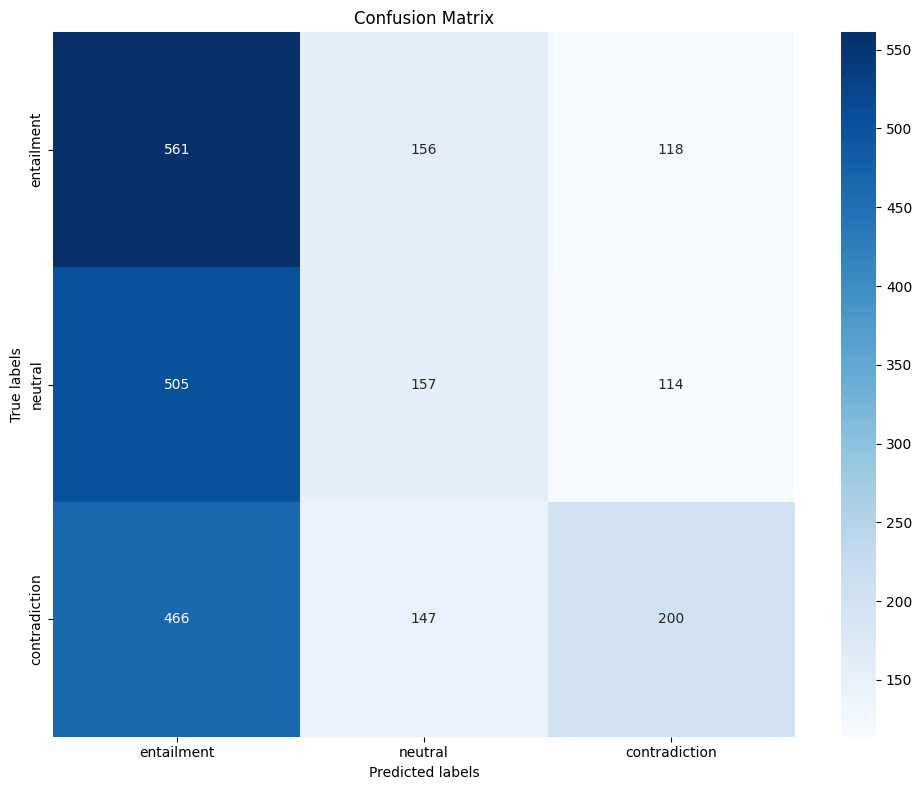

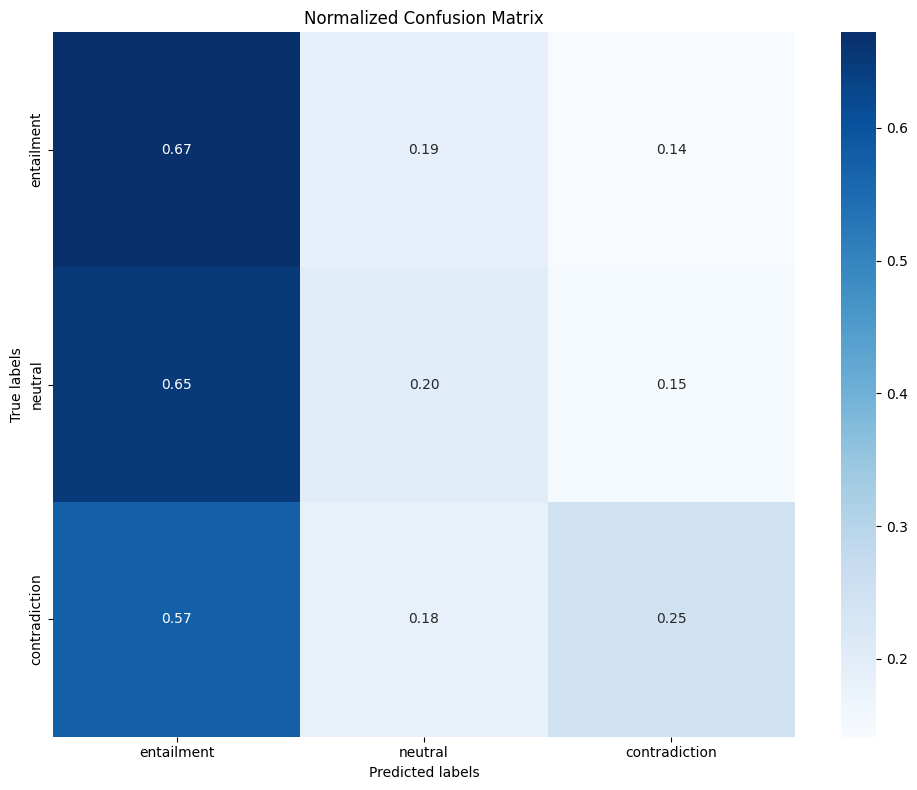

In [238]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate and display confusion matrix
cm = confusion_matrix(data['y_val'], val_predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data['label_map'].values(),
            yticklabels=data['label_map'].values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# If you want a normalized confusion matrix (shows percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=data['label_map'].values(),
            yticklabels=data['label_map'].values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

# Define XGBoost Tuning

In [239]:

def tune_xgboost(data):
    """Tune XGBoost model with Word2Vec features using RandomizedSearchCV."""
    logger.info("\n======== TUNING XGBOOST WITH WORD2VEC ========")
    
    # Define parameter grid
    xgb_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1],
        'min_child_weight': [1, 3, 5]
    }
    
    xgb_clf = XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='mlogloss')
    xgb_search = RandomizedSearchCV(
        xgb_clf, 
        xgb_param_grid, 
        n_iter=10,  # Reduced for faster execution in notebook
        cv=3, 
        scoring='accuracy',
        random_state=SEED,
        n_jobs=-1,
        verbose=1
    )
    
    logger.info("Tuning XGBoost with Word2Vec features...")
    xgb_search.fit(data['train_w2v_combined'], data['y_train'])
    
    logger.info(f"Best parameters for XGB Word2Vec: {xgb_search.best_params_}")
    logger.info(f"Best CV accuracy: {xgb_search.best_score_:.4f}")
    
    best_xgb_w2v = xgb_search.best_estimator_
    val_preds = best_xgb_w2v.predict(data['val_w2v_combined'])
    val_acc = accuracy_score(data['y_val'], val_preds)
    logger.info(f"Validation accuracy: {val_acc:.4f}")
    logger.info(f"Classification Report:\n{classification_report(data['y_val'], val_preds, target_names=data['label_map'].values())}")
    
    return best_xgb_w2v, val_acc, xgb_search.best_params_

# Execute XGBoost Tuning


In [240]:
best_xgb, xgb_acc, xgb_params = tune_xgboost(data)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


# Classification Report XGBoost

In [243]:
def evaluate_xgboost(best_xgb_w2v, data):
    """Evaluate the tuned XGBoost model and print detailed metrics."""
    val_predictions = best_xgb_w2v.predict(data['val_w2v_combined'])
    
    # Calculate individual metrics
    accuracy = accuracy_score(data['y_val'], val_predictions)
    precision = precision_score(data['y_val'], val_predictions, average='weighted')  # Use 'weighted' for multiclass
    recall = recall_score(data['y_val'], val_predictions, average='weighted')
    f1 = f1_score(data['y_val'], val_predictions, average='weighted')
    
    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # For a detailed report per class
    print("\nDetailed Classification Report XGBoost:")
    print(classification_report(data['y_val'], val_predictions, target_names=data['label_map'].values()))


In [244]:
evaluate_xgboost(best_xgb, data)

Accuracy: 0.3853
Precision: 0.3836
Recall: 0.3853
F1 Score: 0.3791

Detailed Classification Report XGBoost:
               precision    recall  f1-score   support

   entailment       0.39      0.52      0.45       835
      neutral       0.38      0.29      0.33       776
contradiction       0.38      0.34      0.36       813

     accuracy                           0.39      2424
    macro avg       0.38      0.38      0.38      2424
 weighted avg       0.38      0.39      0.38      2424



# Generate confusion matrix XGBoost


In [265]:
def print_and_plot_confusion_matrix(y_true, y_pred, label_map):
    """
    Print and plot the confusion matrix for a given set of true and predicted labels.
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - label_map: Dictionary mapping label indices to label names
    """
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    
    # Create a visualization of the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, 
                annot=True,      # Show the numbers in each cell
                fmt='d',          # Use integer formatting
                cmap='Blues',     # Color scheme
                xticklabels=list(label_map.values()),
                yticklabels=list(label_map.values()))
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Show the plot
    plt.show()
 

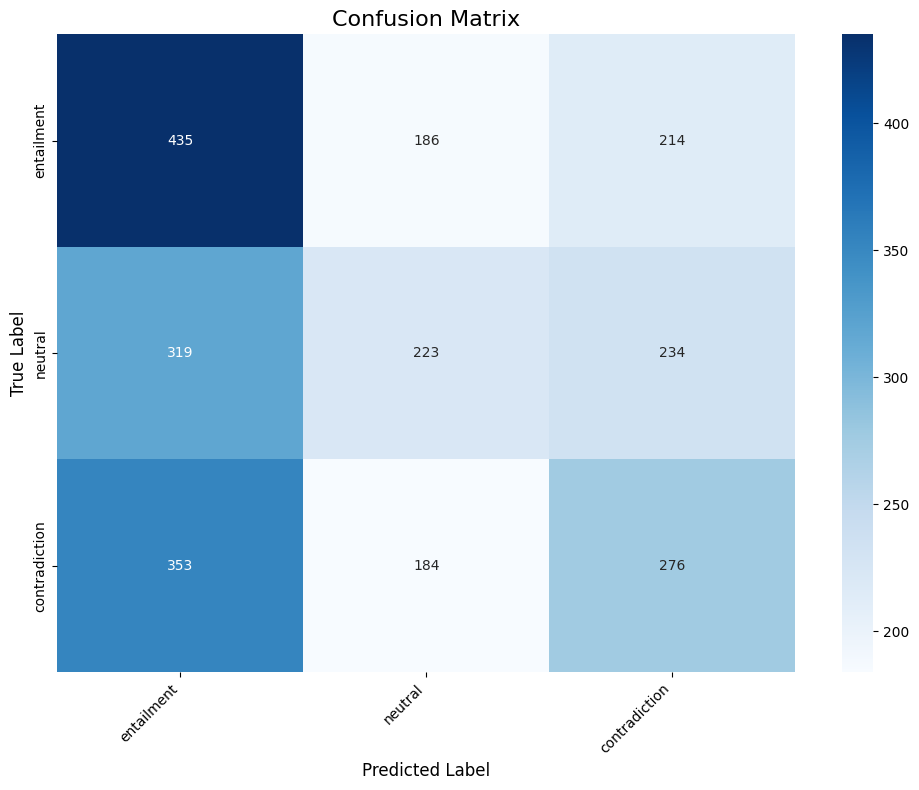

In [266]:
# Assuming you have already generated predictions
val_predictions = best_xgb.predict(data['val_w2v_combined'])

# Call the function to print and plot the confusion matrix
print_and_plot_confusion_matrix(data['y_val'], val_predictions, data['label_map'])

# Tune Decision Tree

In [267]:
def tune_decision_tree(data):
    """
    Tune Decision Tree model with Word2Vec features using RandomizedSearchCV.
    
    Parameters:
    - data: Dictionary containing training and validation data
    
    Returns:
    - Tuple of (best decision tree model, validation accuracy, best parameters)
    """
    logger.info("\n======== TUNING DECISION TREE WITH WORD2VEC ========")
    
    # Define parameter grid for Decision Tree
    dt_param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy'],
        'max_features': [None, 'sqrt', 'log2']
    }
    
    # Create Decision Tree Classifier
    dt_clf = DecisionTreeClassifier(random_state=SEED)
    
    # Set up RandomizedSearchCV
    dt_search = RandomizedSearchCV(
        dt_clf, 
        dt_param_grid, 
        n_iter=10,  # Number of parameter settings sampled
        cv=3,       # 3-fold cross-validation
        scoring='accuracy',
        random_state=SEED,
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    
    # Fit the random search
    logger.info("Tuning Decision Tree with Word2Vec features...")
    dt_search.fit(data['train_w2v_combined'], data['y_train'])
    
    # Log best parameters and score
    logger.info(f"Best parameters for Decision Tree: {dt_search.best_params_}")
    logger.info(f"Best CV accuracy: {dt_search.best_score_:.4f}")
    
    # Get the best estimator
    best_dt_w2v = dt_search.best_estimator_
    
    # Validate on validation set
    val_preds = best_dt_w2v.predict(data['val_w2v_combined'])
    val_acc = accuracy_score(data['y_val'], val_preds)
    
    # Calculate and print all metrics
    precision = precision_score(data['y_val'], val_preds, average='weighted')
    recall = recall_score(data['y_val'], val_preds, average='weighted')
    f1 = f1_score(data['y_val'], val_preds, average='weighted')
    
    print("=" * 50)
    print("DECISION TREE PERFORMANCE (WORD2VEC)")
    print("=" * 50)
    print(f"Accuracy:  {val_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("=" * 50)
    
    logger.info(f"Validation accuracy: {val_acc:.4f}")
    logger.info(f"Validation precision: {precision:.4f}")
    logger.info(f"Validation recall: {recall:.4f}")
    logger.info(f"Validation F1 score: {f1:.4f}")
    logger.info(f"Classification Report:\n{classification_report(data['y_val'], val_preds, target_names=data['label_map'].values())}")
    
    # Print and plot confusion matrix
    print_and_plot_confusion_matrix(data['y_val'], val_preds, data['label_map'])
    
    # Save confusion matrix as an image file
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(data['y_val'], val_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data['label_map'].values(), yticklabels=data['label_map'].values())
    plt.title('Decision Tree Confusion Matrix (Word2Vec)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('decision_tree_confusion_matrix.png')
    plt.close()
    
    return best_dt_w2v, val_acc, dt_search.best_params_

Score and confusion matrix decision tree
--

Fitting 3 folds for each of 10 candidates, totalling 30 fits
DECISION TREE PERFORMANCE (WORD2VEC)
Accuracy:  0.3680
Precision: 0.3742
Recall:    0.3680
F1 Score:  0.3659


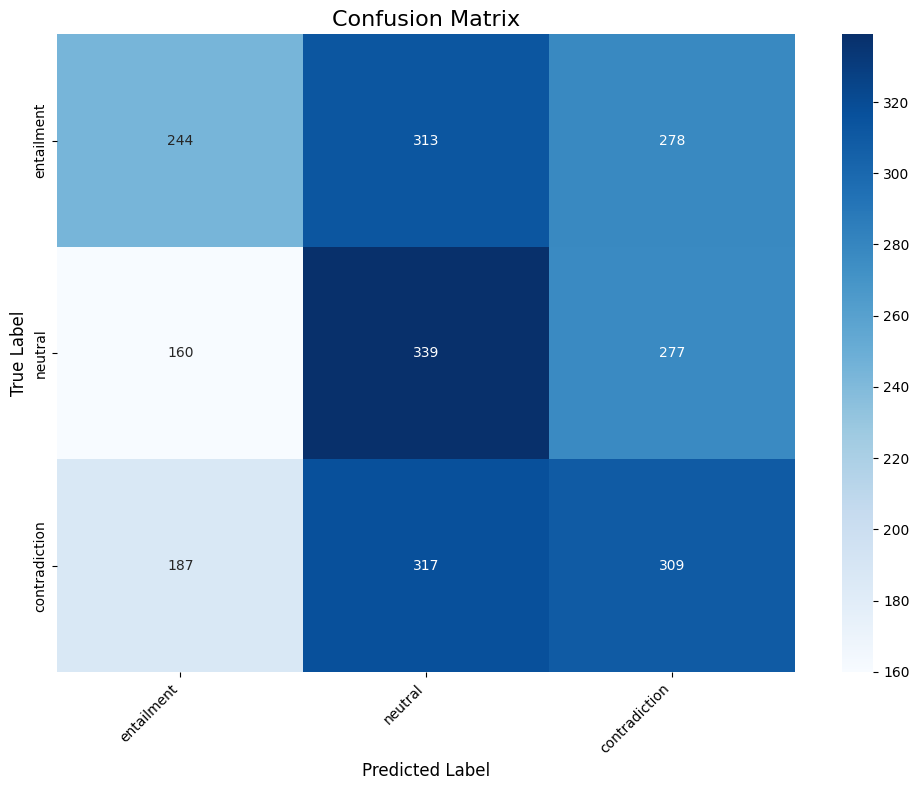

In [268]:
best_model, validation_accuracy, best_params = tune_decision_tree(data)